### Import libraries and change a few settings

In [98]:
import pandas as pd
import numpy as np
import glob
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

os.chdir("C:\\Users\\Family PC\\Desktop\\pythonfiles\\callreport\\balanced_scorecard")

### Concatenate quarterly data files and add some fields for use in calculations as well as metrics

In [99]:
# convert 'Account' column to upper case
acct_desc = pd.read_csv(r'C:\Users\Family PC\Desktop\pythonfiles\callreport\balanced_scorecard\AcctDesc.txt')
acct_desc['Account'] = acct_desc['Account'].str.upper()

# get data file names
path = r'C:\\Users\\Family PC\\Desktop\\pythonfiles\\callreport\\balanced_scorecard' 
filenames = glob.glob(path + "/*.xlsx")

dfs = [] # an empty list to store the dataframes

for filename in filenames:
    df = pd.read_excel(filename) # read excel file
    dfs.append(df) # append to list

# concatenate all dataframes in the list and sort by CU_NUMBER and CYCLE_DATE
big_df = pd.concat(dfs, ignore_index=True)
big_df['CYCLE_DATE'] = pd.to_datetime(big_df['CYCLE_DATE']) #format='%m/%d/%Y',errors='coerce'
big_df = big_df.sort_values(['CU_NUMBER', 'CYCLE_DATE']).reset_index()

big_df['Prior_Year'] = big_df['CYCLE_DATE'].apply(lambda x: x.year - 1)

big_df = big_df.dropna(subset=['CU_NAME'])

# filter big_df for rows where CYCLE_DATE is a 12/31 date
dec_31_df = big_df[big_df['CYCLE_DATE'].dt.month == 12] 

# select only the CU_NUMBER, CYCLE_DATE, and ACCT_010 columns
dec_31_df = dec_31_df[['CU_NUMBER', 'CYCLE_DATE', 'ACCT_010', 'ACCT_025B']] 

# add a new column for the year of the CYCLE_DATE
dec_31_df['Year'] = dec_31_df['CYCLE_DATE'].dt.year 

# create a DataFrame with only the necessary columns from dec_31_df
dec_31_assets = dec_31_df[['CU_NUMBER', 'Year', 'ACCT_010', 'ACCT_025B']].copy()

# add a Cycle_Year column to dec_31_assets
dec_31_assets['Cycle_Year'] = dec_31_assets['Year'] + 1

# rename ACCT_010 to ACCT_010_y in dec_31_assets
dec_31_assets = dec_31_assets.rename(columns={'ACCT_010': 'PYE_Assets', 'ACCT_025B': 'PYE_Loans'})

# convert Year to int
dec_31_assets['Year'] = dec_31_assets['Year'].astype(int)

# add a CYCLE_DATE column to dec_31_assets with December 31 of the Year
dec_31_assets['CYCLE_DATE'] = pd.to_datetime(dec_31_assets['Year'].astype(str) + '-12-31')

# create Cycle_Year column in big_df based on the year of CYCLE_DATE
big_df['Cycle_Year'] = big_df['CYCLE_DATE'].dt.year

# merge big_df with dec_31_assets on CU_NUMBER and Cycle_Year
big_df = big_df.merge(dec_31_assets[['CU_NUMBER', 'Cycle_Year', 'PYE_Assets', 'PYE_Loans']], on=['CU_NUMBER', 'Cycle_Year'], how='left')

# if PYE_Assets is not already in big_df, add it
if 'PYE_Assets' not in big_df.columns:
    big_df['PYE_Assets'] = np.nan
    
# if 'PYE_Loans' not in big_df.columns:
#    big_df['PYE_Loans'] = np.nan

# calculate Average_Assets
big_df['Average_Assets'] = (big_df['ACCT_010'] + big_df['PYE_Assets']) / 2

# calculate Average_loans
# big_df['Average_Loans'] = (big_df['ACCT_025B'] + big_df['PYE_Loans']) / 2

# calculate FTE
# big_df['FTEs'] = (big_df['ACCT_564A'] + (big_df['ACCT_564B'] / 2))

# calculate total borrowings
# big_df['Total_Borrowings'] = big_df['ACCT_656C'] + (big_df['ACCT_860C'])

# calculate total expense
big_df['Total_Expense'] = big_df['ACCT_350'] + (big_df['ACCT_671'])

# calculate total income
big_df['Total_Income'] = big_df['ACCT_115'] + big_df['ACCT_131'] + big_df['ACCT_659'] + big_df['ACCT_IS0020'] + big_df['ACCT_IS0029']

# calculate total shares
# big_df['Total_Nbr_Shares'] = big_df['ACCT_452'] + (big_df['ACCT_454'])+ (big_df['ACCT_458'])+ (big_df['ACCT_451'])+ (big_df['ACCT_453'])+ (big_df['ACCT_455'])

# calculate net charge offs
# big_df['Net_Charge_Offs'] = big_df['ACCT_550'] - (big_df['ACCT_551'])

# make all column names uppercase
big_df.columns = map(str.upper, big_df.columns)

# modify column names
new_col_names = {}
for col in big_df.columns:
    if col != 'ACCOUNT': # skip the 'Account' column
        # get the corresponding account name from the AcctDesc.txt file
        try:
            acct_name = acct_desc[acct_desc['Account'] == col]['AcctName'].values[0]
        except IndexError:
            # handle index error if the account does not exist in AcctDesc.txt
            print(f"Warning: Account {col} does not exist in AcctDesc.txt")
            continue
        # blend the account name with the existing column name
        new_col_name = f"{acct_name} ({col})"
        new_col_names[col] = new_col_name

big_df.rename(columns=new_col_names, inplace=True)

# Calculate Average Retail Member Relationship
big_df['Average Retail Member Relationship'] = (big_df['Total amount of Loans and Leases (ACCT_025B)'] +
                                            big_df['Total Amount of Shares (ACCT_013)'] -
                                            big_df['Total Amount of Non-Member Deposits (ACCT_880)'] -
                                            big_df['Net Member Business Loan Balance (ACCT_400A)']) / \
                                           big_df['Number of current members (not number of accounts) (ACCT_083)']

# Calculate Operating Efficiency
big_df['Operating Efficiency'] = big_df['TOTAL_EXPENSE'] / \
                             big_df['TOTAL_INCOME']

# Calculate Return on Assets
big_df['Return on Assets'] = big_df['Net Income (Loss) (line 11 plus line 17 less line 28) (ACCT_661A)'] / \
                         big_df['PYE_ASSETS']

# Calculate Net Worth Ratio
big_df['Net Worth Ratio'] = big_df['Total Net Worth (ACCT_997)'] / big_df['TOTAL ASSETS (ACCT_010)']

# Format the results
big_df['Average Retail Member Relationship'] = big_df['Average Retail Member Relationship'].round().astype(int)
big_df['Operating Efficiency'] = (big_df['Operating Efficiency'] * 100).round(2)
big_df['Return on Assets'] = (big_df['Return on Assets'] * 100).round(2)
big_df['Net Worth Ratio'] = (big_df['Net Worth Ratio'] * 100).round(2)

big_df = big_df.drop('INDEX', axis=1)

### Filter credit unions based on assets and select a quarter (cycle date).  Also add a credit union field that includes state and asset size.

In [100]:
# Filter credit unions with total assets between $8B and $12B and '3/31/2023' cycle date
target_cu_df = big_df[(big_df['TOTAL ASSETS (ACCT_010)'] >= 9e9) & 
                      (big_df['TOTAL ASSETS (ACCT_010)'] <= 11e9) & 
                      (big_df['CYCLE_DATE'] == '3/31/2023')].copy()

# Create a new field 'Credit Union' that combines CU_Name, State, and Total Assets
target_cu_df['Credit Union'] = (target_cu_df['CU_NAME'] + ' - ' +
                                target_cu_df['STATE'] + ' ($' +
                                (target_cu_df['TOTAL ASSETS (ACCT_010)'] / 1e9).round(1).astype(str) + 'B)')

target_cu_df = target_cu_df[['Credit Union', 'CYCLE_DATE', 'Average Retail Member Relationship', 'Operating Efficiency', 
                                      'Return on Assets', 'Net Worth Ratio']]


### Calculate scores based on minimum and maximum performance.  The best scoring credit union for a particular metric will receive a score of 5 and the worst performing will receive a score of 1.  Note that with some metrics (Operating Efficiency), the lower the number equates to superior performance.

In [101]:
metrics = target_cu_df.iloc[:,2:]
desired_min = 1
desired_max = 5

actual_min = metrics.min()
actual_max = metrics.max()

scaled_metrics = (metrics - actual_min) / (actual_max - actual_min) * (desired_max - desired_min) + desired_min

scaled_metrics['Operating Efficiency'] = (6 - (scaled_metrics['Operating Efficiency']))

scaled_data = pd.concat([target_cu_df.iloc[:,0],scaled_metrics], axis=1)

### In order to calculate an overall balanced score, here we assign weights for the four metrics that sum to 100%.

In [102]:
# Define metric weights
weights = {
    'Average Retail Member Relationship': 0.25,
    'Operating Efficiency': 0.15,
    'Return on Assets': 0.35,
    'Net Worth Ratio': 0.25
}

# Calculate weighted metric scores
weighted_scores = (scaled_metrics * pd.Series(weights)).sum(axis=1)

# Concatenate the cycle date, scaled metrics, and weighted scores
scaled_data = pd.concat([target_cu_df['CYCLE_DATE'], 
                         target_cu_df['Credit Union'],  # Adding Credit Union column
                         scaled_metrics, 
                         weighted_scores], axis=1)

# Rename the weighted scores column
scaled_data.rename(columns={0: 'Weighted Score'}, inplace=True)

### Let's create a chart for each metric showing the scores for each credit union.

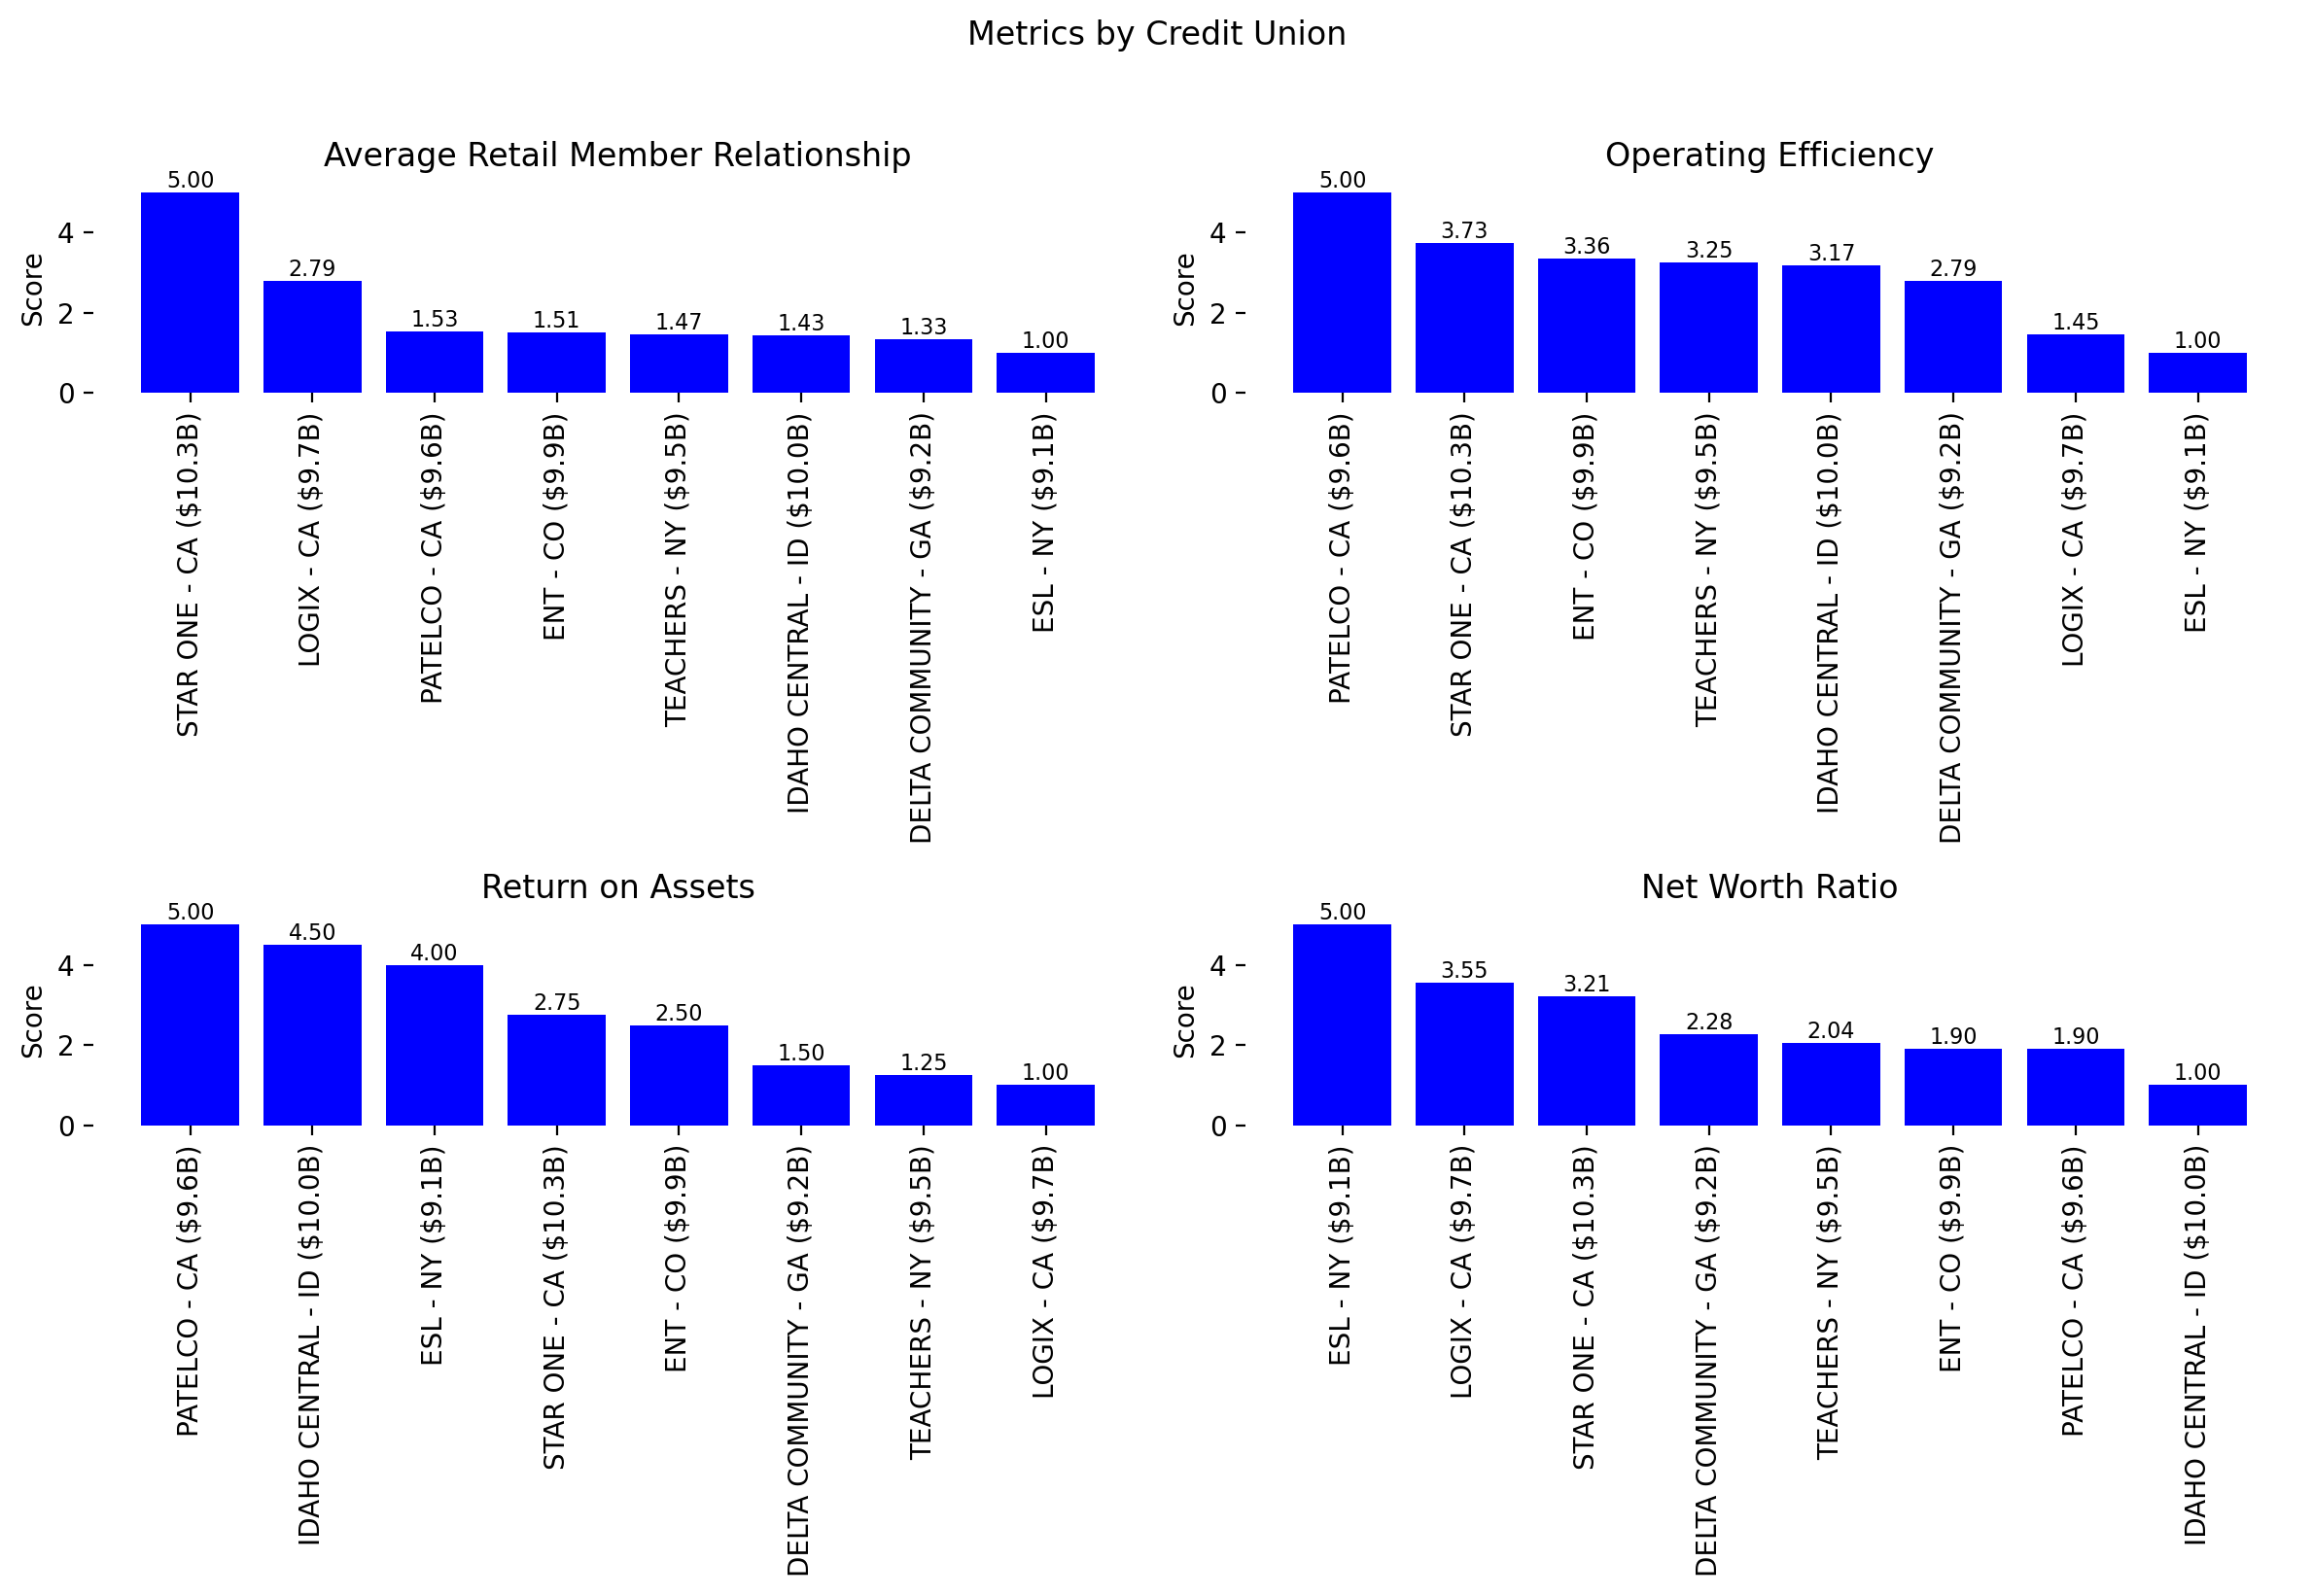

In [103]:
import matplotlib.pyplot as plt

metrics_for_plot = ['Average Retail Member Relationship', 'Operating Efficiency', 'Return on Assets', 'Net Worth Ratio']

# Set up the figure and axes
plt.figure(figsize=(12, 8), dpi=200)

# Iterate through each metric and create a grouped bar plot
for i, metric in enumerate(metrics_for_plot):
    ax = plt.subplot(2, 2, i + 1)
    
    # Sort the data by the metric score in descending order
    sorted_data = scaled_data.sort_values(by=metric, ascending=False)
    
    bars = plt.bar(sorted_data['Credit Union'], sorted_data[metric], color='blue')
    
    # Add data labels to the bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('')
    plt.ylabel('Score')
    plt.title(metric)
    plt.xticks(rotation=90)
    
    # Remove box around each subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
# Add chart labels
plt.suptitle('Metrics by Credit Union', y=1.02)  # Title for the entire chart
plt.tight_layout()

plt.show()


### Here we chart the final results in a horizontal bar chart with the highest scoring credit unions at the top.

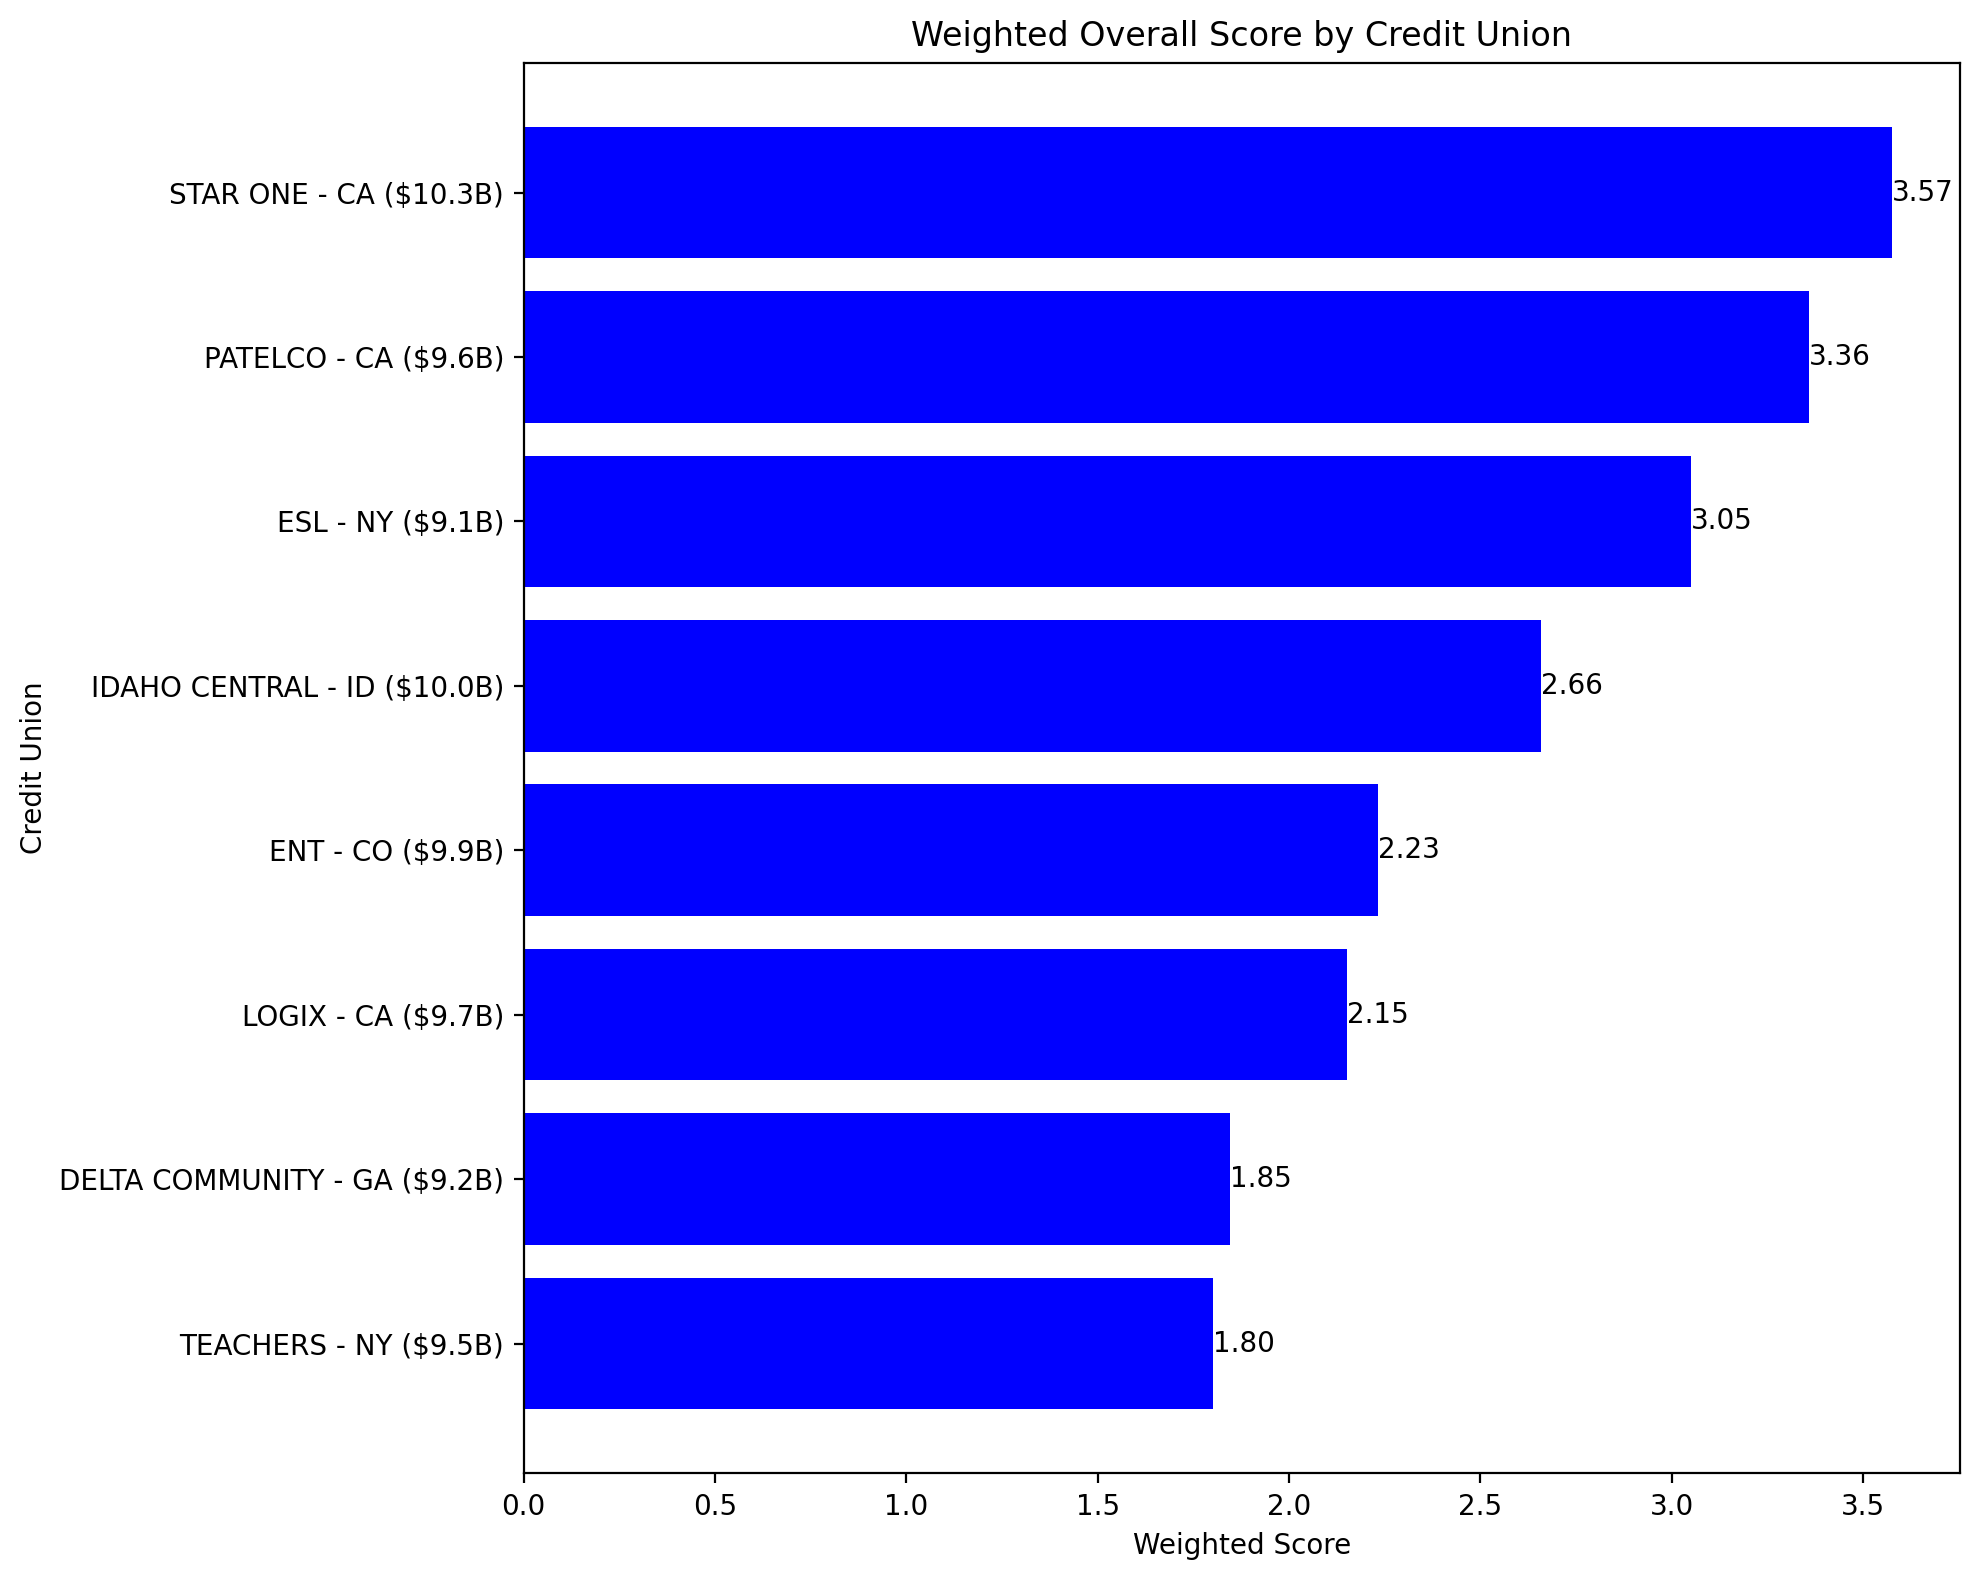

In [104]:
# Sort data by weighted scores
sorted_data = scaled_data.sort_values(by='Weighted Score', ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(10, 8), dpi=200)
bars = plt.barh(sorted_data['Credit Union'], sorted_data['Weighted Score'], color='blue')

# Add data labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', va='center', ha='left', color='black', fontsize=10)

plt.xlabel('Weighted Score')
plt.ylabel('Credit Union')
plt.title('Weighted Overall Score by Credit Union')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.tight_layout()

plt.show()
